In [1]:
import sys
sys.path.append('/datasets/home/99/999/cg260say/project3_codes/')
import numpy as np
import tensorflow as tf
from tensorflow.python.layers.base import Layer
import time
import matplotlib.pyplot as plt
from cifar_readdata import read_dataset

np.random.seed(71)
tf.set_random_seed(71)

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
file_path = '/datasets/CIFAR-10/cifar-10-batches-py/'
classes = ('airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck')
img_height = 32
img_width = 32
n_channel = 3
output_size = 10
batch_size = 64
print_every = 50
dropout_rate = 0.2
starter_learning_rate = 1e-2

In [3]:
dataset = read_dataset(file_path)
train_imgs = dataset.train.images
train_labels = dataset.train.labels
valid_imgs = dataset.validation.images
valid_labels = dataset.validation.labels
test_imgs = dataset.test.images
test_labels = dataset.test.labels

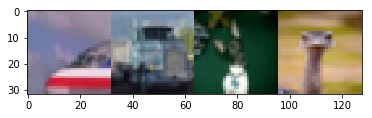

Trainging set: labels: airplane,truck,dog,bird


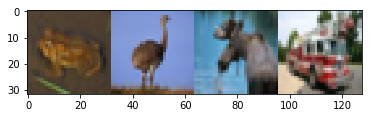

Validation set: labels: frog,bird,deer,truck


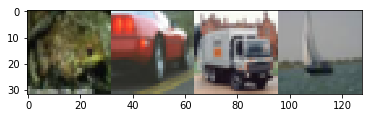

Testing set: labels: frog,automobile,truck,ship


In [4]:
'''
Image show
'''
indices = np.random.randint(1000,size=4)
images = train_imgs[indices].astype(np.int32)
images = np.reshape(images, [4,n_channel, img_height, img_width])
images = np.transpose(images, [0,2,3,1])
images = np.hstack([images[0],images[1],images[2],images[3]])
plt.imshow(images)
plt.show()
labels = train_labels[indices]
print('Trainging set: labels: %s'%(classes[labels[0]]+','+classes[labels[1]]+','+classes[labels[2]]+','+classes[labels[3]]))

images = valid_imgs[indices].astype(np.int32)
images = np.reshape(images, [4,n_channel, img_height, img_width])
images = np.transpose(images, [0,2,3,1])
images = np.hstack([images[0],images[1],images[2],images[3]])
plt.imshow(images)
plt.show()
labels = valid_labels[indices]
print('Validation set: labels: %s'%(classes[labels[0]]+','+classes[labels[1]]+','+classes[labels[2]]+','+classes[labels[3]]))

images = test_imgs[indices].astype(np.int32)
images = np.reshape(images, [4,n_channel, img_height, img_width])
images = np.transpose(images, [0,2,3,1])
images = np.hstack([images[0],images[1],images[2],images[3]])
plt.imshow(images)
plt.show()
labels = test_labels[indices]
print('Testing set: labels: %s'%(classes[labels[0]]+','+classes[labels[1]]+','+classes[labels[2]]+','+classes[labels[3]]))


In [5]:
n_train = len(train_imgs)
n_valid = len(valid_imgs)
n_test = len(test_imgs)
print('Training size = %d, validation size = %d, testing size = %d'%(n_train,n_valid,n_test))

Training size = 45000, validation size = 5000, testing size = 10000


In [6]:
n_epoch = 50
n_train_iteration = n_train // batch_size
n_eval_train = 500
n_eval_valid = n_valid // batch_size
n_eval_test = n_test // batch_size
print('Training: %d epochs, %d iterations per epoch.'%(n_epoch, n_train_iteration))
print('Evaluation: sampling %d batches for training set, %d batches for validation set, %d batches for testing set'%(n_eval_train,n_eval_valid,n_eval_test))

Training: 50 epochs, 703 iterations per epoch.
Evaluation: sampling 500 batches for training set, 78 batches for validation set, 156 batches for testing set


In [7]:
class conv_block(Layer):
    def __init__(self, num_filter, num_conv, block_name):
        self.num_filter = num_filter
        self.num_conv = num_conv
        self.block_name = block_name
        self.batch_norm1 = tf.layers.BatchNormalization(axis=3, name=self.block_name+'_batch1')
        self.batch_norm2 = tf.layers.BatchNormalization(axis=3, name=self.block_name+'_batch2')
        self.batch_norm3 = tf.layers.BatchNormalization(axis=3, name=self.block_name+'_batch3')
        self.conv1 = tf.layers.Conv2D(filters=self.num_filter, kernel_size=3, padding='same', activation=tf.nn.relu, name=self.block_name+'_conv1')
        self.conv2 = tf.layers.Conv2D(filters=self.num_filter, kernel_size=3, padding='same', activation=tf.nn.relu, name=self.block_name+'_conv2')
        self.conv3 = tf.layers.Conv2D(filters=self.num_filter, kernel_size=3, padding='same', activation=tf.nn.relu, name=self.block_name+'_conv3')
        self.maxpool = tf.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid', name=self.block_name+'_maxpool')
    
    def __call__(self, inputs, is_train):
        conv_layer = self.batch_norm1(inputs, training=is_train)
        conv_layer = self.conv1(conv_layer)
        conv_layer = self.batch_norm2(conv_layer, training=is_train)
        conv_layer = self.conv2(conv_layer)
        if self.num_conv == 3:
            conv_layer = self.batch_norm3(conv_layer, training=is_train)
            conv_layer = self.conv3(conv_layer)
        conv_layer = self.maxpool(conv_layer)
        return conv_layer

In [8]:
class Model(Layer):
    def __init__(self):
        self.conv_64 = conv_block(num_filter=64, num_conv=3, block_name='conv64')
        self.conv_128 = conv_block(num_filter=128, num_conv=3, block_name='conv128')
        self.conv_256 = conv_block(num_filter=256, num_conv=3, block_name='conv256')
        self.dens_1 = tf.layers.Dense(units=512, activation=tf.nn.relu, name='dens1')
        self.dens_2 = tf.layers.Dense(units=1024, activation=tf.nn.relu, name='dens2')
        self.drop_1 = tf.layers.Dropout(rate=dropout_rate, name='drop1')
        self.drop_2 = tf.layers.Dropout(rate=dropout_rate, name='drop2')
        self.logit = tf.layers.Dense(units=output_size, name='logit')
        
    def __call__(self, inputs, is_train):
        x = tf.reshape(inputs, [batch_size, n_channel, img_height, img_width])
        x = tf.transpose(x, perm=[0,2,3,1])
        x = self.conv_64(x, is_train)
        x = self.conv_128(x, is_train)
        x = self.conv_256(x, is_train)
        x = tf.layers.flatten(x)
        x = self.dens_1(x)
        x = self.drop_1(x, training=is_train)
        x = self.dens_2(x)
        x = self.drop_2(x, training=is_train)
        logits = self.logit(x)
        return logits

In [9]:
model = Model()

In [10]:
X = tf.placeholder(dtype=tf.float32, shape=[None, 32*32*3])
y = tf.placeholder(dtype=tf.int32, shape=[None])
is_train = tf.placeholder(dtype=tf.bool)
global_step = tf.Variable(0, trainable=False)

y_onehot = tf.one_hot(indices=tf.cast(y, tf.int32), depth=10)
logits = model(X, is_train)
loss = tf.losses.softmax_cross_entropy(y_onehot, logits)

learning_rate = tf.train.exponential_decay(learning_rate=starter_learning_rate, decay_rate=0.96, global_step=global_step, decay_steps=n_train_iteration)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)

predictions = tf.argmax(logits, axis=1)
accuracy = tf.metrics.accuracy(y, predictions)

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_op = optimizer.minimize(loss, global_step=global_step)

In [11]:
def train():
    for n_iter in range(n_train_iteration):
        images, labels = dataset.train.next_batch(batch_size)
        loss_value,_ = sess.run([loss, train_op],feed_dict={X:images, y:labels, is_train:True})
        if (n_iter+1)%print_every == 0:
            print('[ite %d]loss=%f'%(n_iter+1, loss_value))
            
def evaluation():
    train_loss,valid_loss,test_loss = 0.0,0.0,0.0
    train_acc,valid_acc,test_acc = 0.0,0.0,0.0
    for ite in range(n_eval_train):
        images,labels = dataset.train.next_batch(batch_size)
        loss_value,acc = sess.run([loss, accuracy], feed_dict={X:images, y:labels, is_train:False})
        train_loss += loss_value
        train_acc += acc[0]

    train_loss /= n_eval_train
    train_acc /= n_eval_train
    
    for ite in range(n_eval_valid):
        images,labels = dataset.validation.next_batch(batch_size)
        loss_value,acc = sess.run([loss, accuracy], feed_dict={X:images, y:labels, is_train:False})
        valid_loss += loss_value
        valid_acc += acc[0]
    valid_loss /= n_eval_valid
    valid_acc /= n_eval_valid
    
    for ite in range(n_eval_test):
        images,labels = dataset.test.next_batch(batch_size)
        loss_value,acc = sess.run([loss, accuracy], feed_dict={X:images, y:labels, is_train:False})
        test_loss += loss_value
        test_acc += acc[0]
    test_loss /= n_eval_test
    test_acc /= n_eval_test
    
    return train_loss,valid_loss,test_loss,train_acc,valid_acc,test_acc

In [12]:
trainloss_list = []
validloss_list = []
testloss_list = []
trainacc_list = []
validacc_list = []
testacc_list = []

with tf.Session() as sess:
    print('Start:'+time.strftime("%H:%M:%S", time.localtime()))
    tf.global_variables_initializer().run()
    tf.local_variables_initializer().run()
    for epoch in range(n_epoch):
        train()
        trl,val,tel,tra,vaa,tea = evaluation()
        trainloss_list.append(trl)
        validloss_list.append(val)
        testloss_list.append(tel)
        trainacc_list.append(tra)
        validacc_list.append(vaa)
        testacc_list.append(tea)
        print('[Epoch %d]'%(epoch+1)+time.strftime("%H:%M:%S", time.localtime())+'  learning_rate=%f'%(sess.run(optimizer._learning_rate)))
        print('train_loss=%f, train_acc=%f, valid_loss=%f, valid_acc=%f, test_loss=%f, test_acc=%f'%(trl,tra,val,vaa,tel,tea))

Start:16:57:08
[ite 50]loss=1.946779
[ite 100]loss=1.856141
[ite 150]loss=1.826822
[ite 200]loss=1.788843
[ite 250]loss=1.446883
[ite 300]loss=1.353850
[ite 350]loss=1.349518
[ite 400]loss=1.189506
[ite 450]loss=1.382921
[ite 500]loss=1.635401
[ite 550]loss=1.193033
[ite 600]loss=1.316163
[ite 650]loss=1.356598
[ite 700]loss=1.271722
[Epoch 1]16:57:32  learning_rate=0.009600
train_loss=1.137434, train_acc=0.588750, valid_loss=1.197469, valid_acc=0.588715, test_loss=1.175776, test_acc=0.585956
[ite 50]loss=1.283471
[ite 100]loss=1.137249
[ite 150]loss=1.328173
[ite 200]loss=1.137055
[ite 250]loss=1.270491
[ite 300]loss=1.037728
[ite 350]loss=0.944036
[ite 400]loss=1.003376
[ite 450]loss=1.151519
[ite 500]loss=0.885300
[ite 550]loss=1.048901
[ite 600]loss=1.074350
[ite 650]loss=1.186720
[ite 700]loss=0.841102
[Epoch 2]16:57:53  learning_rate=0.009216
train_loss=0.924376, train_acc=0.603840, valid_loss=1.010617, valid_acc=0.620479, test_loss=1.000922, test_acc=0.622135
[ite 50]loss=0.9285

[ite 50]loss=0.004424
[ite 100]loss=0.008818
[ite 150]loss=0.009703
[ite 200]loss=0.003171
[ite 250]loss=0.013147
[ite 300]loss=0.016330
[ite 350]loss=0.009453
[ite 400]loss=0.008478
[ite 450]loss=0.009476
[ite 500]loss=0.046178
[ite 550]loss=0.017108
[ite 600]loss=0.009520
[ite 650]loss=0.005876
[ite 700]loss=0.023724
[Epoch 18]17:03:29  learning_rate=0.004796
train_loss=0.002713, train_acc=0.852140, valid_loss=0.890154, valid_acc=0.854826, test_loss=0.886932, test_acc=0.854368
[ite 50]loss=0.007561
[ite 100]loss=0.010385
[ite 150]loss=0.040733
[ite 200]loss=0.014639
[ite 250]loss=0.004754
[ite 300]loss=0.002918
[ite 350]loss=0.017773
[ite 400]loss=0.020217
[ite 450]loss=0.040797
[ite 500]loss=0.005891
[ite 550]loss=0.005871
[ite 600]loss=0.023331
[ite 650]loss=0.012863
[ite 700]loss=0.007431
[Epoch 19]17:03:50  learning_rate=0.004604
train_loss=0.002210, train_acc=0.856759, valid_loss=0.923531, valid_acc=0.859213, test_loss=0.906996, test_acc=0.858751
[ite 50]loss=0.003779
[ite 100]l

[ite 50]loss=0.000712
[ite 100]loss=0.003472
[ite 150]loss=0.000701
[ite 200]loss=0.001450
[ite 250]loss=0.002917
[ite 300]loss=0.002802
[ite 350]loss=0.000630
[ite 400]loss=0.002064
[ite 450]loss=0.002710
[ite 500]loss=0.007825
[ite 550]loss=0.001903
[ite 600]loss=0.007291
[ite 650]loss=0.006657
[ite 700]loss=0.002557
[Epoch 35]17:09:26  learning_rate=0.002396
train_loss=0.000145, train_acc=0.894590, valid_loss=1.010098, valid_acc=0.895497, test_loss=1.021147, test_acc=0.895100
[ite 50]loss=0.002152
[ite 100]loss=0.004452
[ite 150]loss=0.001319
[ite 200]loss=0.002936
[ite 250]loss=0.005576
[ite 300]loss=0.004777
[ite 350]loss=0.000365
[ite 400]loss=0.001029
[ite 450]loss=0.003599
[ite 500]loss=0.000878
[ite 550]loss=0.001307
[ite 600]loss=0.000655
[ite 650]loss=0.002307
[ite 700]loss=0.004155
[Epoch 36]17:09:47  learning_rate=0.002300
train_loss=0.000115, train_acc=0.895830, valid_loss=0.990394, valid_acc=0.896700, test_loss=0.999612, test_acc=0.896311
[ite 50]loss=0.000689
[ite 100]l